# Trabalho de Ciência de Dados: Perfil e Satisfação do Consumidor na Olist

Contexto: o crescimento do comércio eletrônico gerou grandes volumes de dados. Vamos usar o dataset público da Olist para revelar padrões de compra, preferências regionais e fatores críticos de satisfação do cliente.

Perguntas norteadoras:
1. Qual é o perfil de compra dos clientes da Olist?
2. Quais fatores mais influenciam a satisfação do cliente?
3. Quais categorias de produtos são mais compradas e em quais regiões (preferências regionais)?

Estrutura do notebook:
- Importação e descrição dos dados.
- Exploração inicial (perfil, volumes, regiões, categorias).
- Pré-processamento e engenharia de atributos para modelar satisfação.
- Particionamento, treino de modelos e avaliação (acurácia, ROC).
- Insights e recomendações.

Trabalho realizado por: Pedro Guilherme de Barros Zenatte - 13676919

## 1. Preparação do ambiente e carregamento dos dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

!pip install xgboost
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid", palette="viridis")

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Nesta primeira etapa foi realizada a leitura de todos os datasets da Olist usando o pandas. Cada arquivo corresponde a uma parte do ecossistema de um e-commerce — clientes, pedidos, itens, vendedores, pagamentos, avaliações etc. Depois de carregar os dados, foi impresso o tamanho de cada tabela para verificar suas dimensões.

Por exemplo, a tabela customers tem 99 mil clientes, a orders também tem 99 mil pedidos, a products tem cerca de 33 mil produtos diferentes, enquanto geolocation é a maior, com mais de 1 milhão de registros de coordenadas de CEPs. Esse diagnóstico inicial é importante para entendermos o tamanho de cada conjunto e como eles vão se relacionar nas próximas etapas.

In [ ]:
# Caminhos dos datasets no Google Drive
base_path = Path("/content/drive/MyDrive/Colab Notebooks/TrabalhoDados")
paths = {
    "customers": base_path / "olist_customers_dataset.csv",
    "geolocation": base_path / "olist_geolocation_dataset.csv",
    "order_items": base_path / "olist_order_items_dataset.csv",
    "payments": base_path / "olist_order_payments_dataset.csv",
    "reviews": base_path / "olist_order_reviews_dataset.csv",
    "orders": base_path / "olist_orders_dataset.csv",
    "products": base_path / "olist_products_dataset.csv",
    "sellers": base_path / "olist_sellers_dataset.csv",
    "category_translation": base_path / "product_category_name_translation.csv",
}

# Leitura dos dados
customers = pd.read_csv(paths["customers"])
geolocation = pd.read_csv(paths["geolocation"])
order_items = pd.read_csv(paths["order_items"])
payments = pd.read_csv(paths["payments"])
reviews = pd.read_csv(paths["reviews"])
orders = pd.read_csv(
    paths["orders"],
    parse_dates=["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"],
)
products = pd.read_csv(paths["products"])
sellers = pd.read_csv(paths["sellers"])
category_translation = pd.read_csv(paths["category_translation"])

info = []

datasets = {
    "Clientes (customers)": customers,
    "Geolocalização (geolocation)": geolocation,
    "Itens do pedido (order_items)": order_items,
    "Pagamentos (payments)": payments,
    "Avaliações (reviews)": reviews,
    "Pedidos (orders)": orders,
    "Produtos (products)": products,
    "Vendedores (sellers)": sellers,
    "Tradução de categorias (category_translation)": category_translation
}

for name, df in datasets.items():
    info.append({
        "Dataset": name,
        "Linhas": df.shape[0],
        "Colunas": df.shape[1],
        "Nome das colunas": ", ".join(df.columns)
    })

tabela_info = pd.DataFrame(info)

tabela_info

,Dataset,Linhas,Colunas,Nome das colunas
0,Clientes (customers),99441,5,"customer_id, customer_unique_id, customer_zip_..."
1,Geolocalização (geolocation),1000163,5,"geolocation_zip_code_prefix, geolocation_lat, ..."
2,Itens do pedido (order_items),112650,7,"order_id, order_item_id, product_id, seller_id..."
3,Pagamentos (payments),103886,5,"order_id, payment_sequential, payment_type, pa..."
4,Avaliações (reviews),99224,7,"review_id, order_id, review_score, review_comm..."
5,Pedidos (orders),99441,8,"order_id, customer_id, order_status, order_pur..."
6,Produtos (products),32951,9,"product_id, product_category_name, product_nam..."
7,Vendedores (sellers),3095,4,"seller_id, seller_zip_code_prefix, seller_city..."
8,Tradução de categorias (category_translation),71,2,"product_category_name, product_category_name_e..."


### Breve dicionário
- `orders`: informações de pedidos (carimbo de data, status, entrega estimada/real).
- `order_items`: itens do pedido (produto, vendedor, preço, frete).
- `order_reviews`: notas (1 a 5) e datas de avaliação.
- `products`: atributos de produto (dimensões, categoria).
- `customers` e `sellers`: localização de clientes e vendedores.
- `category_translation`: tradução das categorias para inglês (facilita leitura).

## 2. Exploração inicial
Vamos unir tabelas principais para entender volumes, categorias e regiões.

Vamos integrar todos os datasets separados da Olist, relacionando-os corretamente pelas chaves, e também adicinar a tradução da categoria através da tabela auxiliar (category_translation). Como resultado, temos uma única tabela completa, itemns_products, a qual reúne todas as informações necessárias para análise, como:

* Preço
* Frete
* Categoria (PT e EN)
* Peso, dimensões
* Status da entrega
* Timestamps do pedido (data e hora)
* Localização do cliente
* Vendedor
* e muito mais

E cada linha representa um item vendida, já com todo o contexto.

Dessa forma, a base integrada é o início para toda a análise.

In [ ]:
# Tradução do nome de categoria para inglês
products = products.merge(
    category_translation.rename(columns={"product_category_name": "product_category_name", "product_category_name_english": "product_category_name_english"}),
    on="product_category_name",
    how="left",
)

# Base de itens + produtos + pedidos + clientes
items_products = (
    order_items
    .merge(products, on="product_id", how="left")
    .merge(orders, on="order_id", how="left")
    .merge(customers, on="customer_id", how="left")
)
items_products["order_purchase_date"] = items_products["order_purchase_timestamp"].dt.date

print(items_products[["order_id", "order_item_id"]].drop_duplicates().shape)
items_products.head()

traducao_colunas = {
    "order_id": "ID do pedido",
    "order_item_id": "Item do pedido",
    "product_id": "ID do produto",
    "seller_id": "ID do vendedor",
    "shipping_limit_date": "Data limite de envio",
    "price": "Preço",
    "freight_value": "Valor do frete",
    "product_category_name": "Categoria (pt)",
    "product_category_name_english": "Categoria (en)",

    "product_name_lenght": "Tamanho do nome",
    "product_description_lenght": "Tamanho da descrição",
    "product_photos_qty": "Número de fotos",
    "product_weight_g": "Peso (g)",
    "product_length_cm": "Comprimento (cm)",
    "product_height_cm": "Altura (cm)",
    "product_width_cm": "Largura (cm)",

    "customer_id": "ID do cliente",
    "customer_unique_id": "ID único do cliente",
    "customer_zip_code_prefix": "CEP do cliente",
    "customer_city": "Cidade do cliente",
    "customer_state": "Estado do cliente",

    "order_status": "Status do pedido",
    "order_purchase_timestamp": "Data/hora da compra",
    "order_approved_at": "Data de aprovação",
    "order_delivered_carrier_date": "Data envio transportadora",
    "order_delivered_customer_date": "Data entrega cliente",
    "order_estimated_delivery_date": "Entrega estimada",

    "order_purchase_date": "Data da compra",
}

novo_nome_colunas = {
    old: f"{pt} ({old})"
    for old, pt in traducao_colunas.items()
    if old in items_products.columns
}

# Não substitui items_products, só cria uma cópia para visualização
items_products_pt = items_products.rename(columns=novo_nome_colunas)
items_products_pt.head()

(112650, 2)


,ID do pedido (order_id),Item do pedido (order_item_id),ID do produto (product_id),ID do vendedor (seller_id),Data limite de envio (shipping_limit_date),Preço (price),Valor do frete (freight_value),Categoria (pt) (product_category_name),Tamanho do nome (product_name_lenght),Tamanho da descrição (product_description_lenght),Número de fotos (product_photos_qty),Peso (g) (product_weight_g),Comprimento (cm) (product_length_cm),Altura (cm) (product_height_cm),Largura (cm) (product_width_cm),Categoria (en) (product_category_name_english),ID do cliente (customer_id),Status do pedido (order_status),Data/hora da compra (order_purchase_timestamp),Data de aprovação (order_approved_at),Data envio transportadora (order_delivered_carrier_date),Data entrega cliente (order_delivered_customer_date),Entrega estimada (order_estimated_delivery_date),ID único do cliente (customer_unique_id),CEP do cliente (customer_zip_code_prefix),Cidade do cliente (customer_city),Estado do cliente (customer_state),Data da compra (order_purchase_date)
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,2017-02-04


Depois de integrar todas as bases de dados, realizamos uma análise exploratória inicial. Primeiro, observo onde estão os clientes, para analisar em qual estado está a forte concentração de clientes. Depois, verifico as categorias mais vendidas. Por fim, analiso as notas de review, que mostram predominância de notas 5, indicando boa satisfação geral.

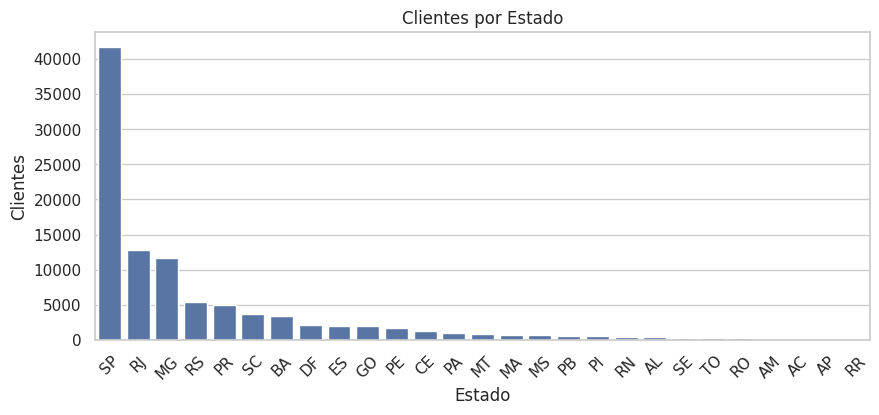

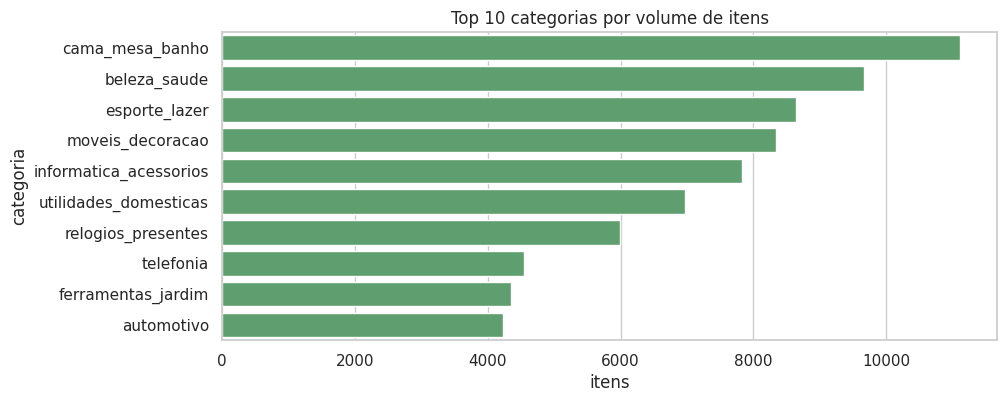

/tmp/ipython-input-2552986347.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


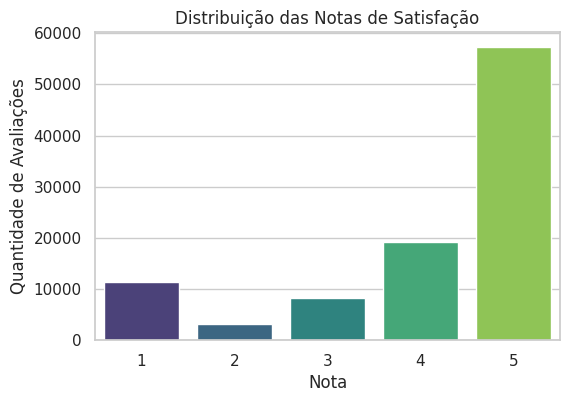

In [ ]:
# Perfil geral de clientes (quantidade por estado)
state_counts = (
    customers["customer_state"]
    .value_counts()
    .rename_axis("Estado")          # eixo x
    .reset_index(name="Clientes")   # eixo y
)
plt.figure(figsize=(10,4))
sns.barplot(data=state_counts, x="Estado", y="Clientes", color="#4c72b0")
plt.title("Clientes por Estado")
plt.xticks(rotation=45)
plt.show()

# Top 10 categorias por volume de itens
top_categories = (
    items_products["product_category_name"].fillna("desconhecido")
    .value_counts()
    .head(10)
    .reset_index(name="itens")
    .rename(columns={"product_category_name": "categoria"})
)
plt.figure(figsize=(10,4))
sns.barplot(data=top_categories, y="categoria", x="itens", color="#55a868")
plt.title("Top 10 categorias por volume de itens")
plt.show()

# Distribuição de notas de satisfação
plt.figure(figsize=(6,4))
sns.countplot(
    data=reviews,
    x="review_score",
    palette="viridis",
    order=sorted(reviews["review_score"].unique())
)
plt.title("Distribuição das Notas de Satisfação")
plt.xlabel("Nota")
plt.ylabel("Quantidade de Avaliações")
plt.show()


No primeiro gráfico, analisamos a distribuição de clientes por estado. Observa-se que São Paulo concentra disparadamente o maior número de clientes, seguido por RJ, MG e RS. Desse modo, isso mostra que a base da Olist é fortemente dominada por clientes do Sudeste e Sul.

O segundo gráfico, examinamos quais categorias de produtos têm maior volume de itens vendidos. As líderes são ‘casa_mesa_banho’, ‘beleza_saúde’ e ‘esporte_lazer’. Essas três juntas representam boa parte das vendas totais da plataforma, indicando uma forte presença de produtos de uso doméstico, beleza e lazer.

Já nó último gráfico, analisamos a distribuição das notas, mostrando que a maioria das avaliações são positivas, com destaque para a nota 5, que é disparadamente a mais frequente. Notas baixas (1 e 2) também aparecem, mas representam uma parcela bem menor. Isso indica que, no geral, os clientes tendem a avaliar bem suas compras.

### Observações iniciais
- Volume maior de clientes em SP, RJ e MG (mercado concentrado no Sudeste).
- Categorias de ‘casa_mesa_banho’, ‘beleza_saúde’ e ‘esporte_lazer’ aparecem entre as mais vendidas.
- Notas de satisfação são enviesadas para 5, mas há proporção relevante de notas 1–3, abrindo espaço para explicar a insatisfação.

## 3. Pré-processamento
### Foco: entender fatores que influenciam a satisfação (nota de review) e como variam por região e categoria.

Criaremos atributos por pedido:
- `delivery_delay` (dias entre entrega real e estimada; positivo indica atraso).
- `purchase_approval_time` (tempo em horas entre compra e aprovação do pagamento).
- `items_count`, `total_price`, `freight_ratio` (frete/total).
- Dimensões do produto (peso/volume) e categoria traduzida.
- Localização do cliente (estado).

Vamos preparar o dataset para modelagem, ou seja, teremos apenas as informações mais relevantes das tabelas, como itens, pedidos, produtos, clientes e reviews. Também criaremos variáveis importantes para prever a satisfação do cliente, como tempo de aprovação, atraso da entrega, volume do produto, relação frete/preço, entre outras.

Após isso, transformamos a nota do review em binario, de modo que 1 significa o cliente satisfeito. OBS: O model_df que é usado para treinar os modelos de machine learning.

In [ ]:
# Join para modelagem de satisfação por pedido
base = (
    order_items
    .merge(orders, on="order_id", how="left")
    .merge(products, on="product_id", how="left")
    .merge(customers, on="customer_id", how="left")
    .merge(reviews[["order_id", "review_score"]], on="order_id", how="inner")
)

# Agregação por pedido (há pedidos com múltiplos itens)
agg = {
    "price": "sum",
    "freight_value": "sum",
    "order_item_id": "max",
    "product_weight_g": "mean",
    "product_length_cm": "mean",
    "product_height_cm": "mean",
    "product_width_cm": "mean",
}
model_df = (
    base
    .groupby(["order_id", "customer_id", "customer_state", "product_category_name_english", "review_score"])
    .agg(agg)
    .reset_index()
    .rename(columns={"order_item_id": "items_count"})
)

# Features de tempo
orders_time = orders[[
    "order_id", "order_purchase_timestamp", "order_approved_at",
    "order_delivered_customer_date", "order_estimated_delivery_date"
]].copy()
orders_time["purchase_approval_time"] = (
    orders_time["order_approved_at"] - orders_time["order_purchase_timestamp"]
).dt.total_seconds() / 3600
orders_time["delivery_delay"] = (
    orders_time["order_delivered_customer_date"] - orders_time["order_estimated_delivery_date"]
).dt.days

model_df = model_df.merge(
    orders_time[["order_id", "purchase_approval_time", "delivery_delay"]],
    on="order_id",
    how="left",
)

# Ajustes finais
model_df["total_price"] = model_df["price"] + model_df["freight_value"]
model_df["freight_ratio"] = model_df["freight_value"] / model_df["total_price"]
model_df["product_volume_cm3"] = (
    model_df["product_length_cm"] * model_df["product_height_cm"] * model_df["product_width_cm"]
)

# Alvo binário: 1 se review >= 4 (satisfeito), 0 caso contrário
model_df = model_df.dropna(subset=["review_score"])  # garante alvo presente
model_df["target_satisfied"] = (model_df["review_score"] >= 4).astype(int)

#model_df.head()

# --------------------------------------------
# Versão apenas para exibição:
# --------------------------------------------

map_pt = {
    "order_id": "ID do pedido",
    "customer_id": "ID do cliente",
    "customer_state": "Estado do cliente",
    "product_category_name_english": "Categoria do produto (inglês)",
    "review_score": "Nota da avaliação",

    "price": "Valor dos produtos",
    "freight_value": "Valor do frete",
    "items_count": "Quantidade de itens",
    "product_weight_g": "Peso médio (g)",
    "product_length_cm": "Comprimento médio (cm)",
    "product_height_cm": "Altura média (cm)",
    "product_width_cm": "Largura média (cm)",

    "purchase_approval_time": "Tempo até aprovação (h)",
    "delivery_delay": "Atraso na entrega (dias)",
    "total_price": "Valor total (produto + frete)",
    "freight_ratio": "Proporção do frete)",
    "product_volume_cm3": "Volume médio (cm³)",
    "target_satisfied": "Satisfeito (1 = sim, 0 = não)",
}

# Cria labels no formato: "Nome PT (nome_original)"
map_pt_com_original = {
    col: f"{pt} ({col})" for col, pt in map_pt.items()
}

model_df_pt = model_df.rename(columns=map_pt_com_original)
model_df_pt.head()

,ID do pedido (order_id),ID do cliente (customer_id),Estado do cliente (customer_state),Categoria do produto (inglês) (product_category_name_english),Nota da avaliação (review_score),Valor dos produtos (price),Valor do frete (freight_value),Quantidade de itens (items_count),Peso médio (g) (product_weight_g),Comprimento médio (cm) (product_length_cm),Altura média (cm) (product_height_cm),Largura média (cm) (product_width_cm),Tempo até aprovação (h) (purchase_approval_time),Atraso na entrega (dias) (delivery_delay),Valor total (produto + frete) (total_price),Proporção do frete) (freight_ratio),Volume médio (cm³) (product_volume_cm3),"Satisfeito (1 = sim, 0 = não) (target_satisfied)"
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,RJ,cool_stuff,5,58.90,13.29,1,650.0,28.0,9.0,14.0,0.775833,-9.0,72.19,0.184098,3528.0,1
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,SP,pet_shop,4,239.90,19.93,1,30000.0,50.0,30.0,40.0,0.201944,-3.0,259.83,0.076704,60000.0,1
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,MG,furniture_decor,5,199.00,17.87,1,3050.0,33.0,13.0,33.0,0.249722,-14.0,216.87,0.082400,14157.0,1
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,SP,perfumery,4,12.99,12.79,1,200.0,16.0,10.0,15.0,0.161944,-6.0,25.78,0.496121,2400.0,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,SP,garden_tools,5,199.90,18.14,1,3750.0,35.0,40.0,30.0,0.206111,-16.0,218.04,0.083196,42000.0,1


### Avaliação de valores ausentes e distribuição das features
Vamos checar proporções de ausentes e algumas estatísticas para validar se precisamos imputar ou descartar colunas.

In [ ]:
# Dicionário de tradução
map_pt = {
    "order_id": "ID do pedido",
    "customer_id": "ID do cliente",
    "customer_state": "Estado do cliente",
    "product_category_name_english": "Categoria do produto (inglês)",
    "review_score": "Nota da avaliação",

    "price": "Valor dos produtos",
    "freight_value": "Valor do frete",
    "items_count": "Quantidade de itens",
    "product_weight_g": "Peso médio (g)",
    "product_length_cm": "Comprimento médio (cm)",
    "product_height_cm": "Altura média (cm)",
    "product_width_cm": "Largura média (cm)",

    "purchase_approval_time": "Tempo até aprovação (h)",
    "delivery_delay": "Atraso na entrega (dias)",
    "total_price": "Valor total (produto + frete)",
    "freight_ratio": "Proporção do frete",
    "product_volume_cm3": "Volume médio (cm³)",
    "target_satisfied": "Satisfeito (1 = sim, 0 = não)",
}

# Constrói nomes no formato: NOME_PT (original)
map_pt_original = {col: f"{pt} ({col})" for col, pt in map_pt.items()}

# Cálculo do missing normal
missing_pct = model_df.isnull().mean().sort_values(ascending=False)

# Aplica tradução apenas no índice
missing_pct = missing_pct.rename(index=map_pt_original)

# Exibe somente as variáveis com missing
missing_pct[missing_pct > 0].head(10)

,0
Atraso na entrega (dias) (delivery_delay),0.020973
Tempo até aprovação (h) (purchase_approval_time),0.000133
Altura média (cm) (product_height_cm),0.000010
Largura média (cm) (product_width_cm),0.000010
Peso médio (g) (product_weight_g),0.000010
Comprimento médio (cm) (product_length_cm),0.000010
Volume médio (cm³) (product_volume_cm3),0.000010


Acima calculamos a porcentagem de valores ausentes em cada coluna, mostrando apenas as que possuem valores faltantes. O único atributo com uma quantidade mais relevante de ausência é o Atraso na entrega (dias) (delivery_delay).

In [ ]:
numeric_cols = [
    "price", "freight_value", "items_count", "product_weight_g",
    "product_volume_cm3", "purchase_approval_time", "delivery_delay",
    "total_price", "freight_ratio"
]

# dicionário PT + nome original
map_pt = {
    "price": "Valor dos produtos",
    "freight_value": "Valor do frete",
    "items_count": "Quantidade de itens",
    "product_weight_g": "Peso médio (g)",
    "product_volume_cm3": "Volume médio (cm³)",
    "purchase_approval_time": "Tempo até aprovação (h)",
    "delivery_delay": "Atraso na entrega (dias)",
    "total_price": "Valor total (produto + frete)",
    "freight_ratio": "Proporção do frete",
}

map_pt_original = {col: f"{pt} ({col})" for col, pt in map_pt.items()}

descricao_pt = (
    model_df[numeric_cols]
        .describe()
        .rename(index={
            "count": "contagem",
            "mean": "média",
            "std": "desvio_padrao",
            "min": "mín",
            "25%": "p25",
            "50%": "mediana",
            "75%": "p75",
            "max": "máx",
        })
        .T
        .rename(index=map_pt_original)
)

descricao_pt


,contagem,média,desvio_padrao,mín,p25,mediana,p75,máx
Valor dos produtos (price),97459.0,136.905599,208.657112,0.85,45.900000,85.500000,149.900000,13440.000000
Valor do frete (freight_value),97459.0,22.741725,21.527400,0.00,13.790000,17.170000,23.990000,1794.960000
Quantidade de itens (items_count),97459.0,1.142604,0.537365,1.00,1.000000,1.000000,1.000000,21.000000
Peso médio (g) (product_weight_g),97458.0,2106.295435,3757.966374,0.00,300.000000,700.000000,1813.000000,40425.000000
Volume médio (cm³) (product_volume_cm3),97458.0,15250.778669,23376.204904,168.00,2816.000000,6480.000000,18400.000000,296208.000000
Tempo até aprovação (h) (purchase_approval_time),97446.0,10.342456,21.515722,0.00,0.215278,0.343889,14.581042,1450.866389
Atraso na entrega (dias) (delivery_delay),95415.0,-11.957355,10.112151,-147.00,-17.000000,-13.000000,-7.000000,188.000000
Valor total (produto + frete) (total_price),97459.0,159.647324,218.379825,7.28,61.800000,104.680000,176.160000,13664.080000
Proporção do frete (freight_ratio),97459.0,0.209102,0.126106,0.00,0.116616,0.183256,0.276256,0.963283


Com a tabela de estatísticas descritivas das variáveis numéricas, conseguimos observar características importantes, como distribuição dos preços, valor de frete, número de itens, dimensões dos produtos...

Os resultados revelam que a maioria dos pedidos tem apenas um item, a entrega costuma ocorrer antes da data prevista, e o frete pode representar até 20% do valor total em média. Essa análise inicial ajuda a entender comportamento da base e possíveis influências na satisfação do cliente.”

### Decisões de pré-processamento
- Preencher atrasos ausentes (`delivery_delay`) com 0 para casos sem entrega reportada (assumir entrega no prazo);
- Preencher tempo de aprovação ausente com mediana;
- Preencher atributos de produto ausentes com mediana;
- Manter apenas `customer_state` e `product_category_name_english` como categóricas principais.

In [ ]:
model_df["delivery_delay"].fillna(0, inplace=True)
model_df["purchase_approval_time"].fillna(model_df["purchase_approval_time"].median(), inplace=True)
for col in ["product_weight_g", "product_volume_cm3"]:
    model_df[col].fillna(model_df[col].median(), inplace=True)
model_df["product_category_name_english"].fillna("unknown", inplace=True)

model_df = model_df.dropna(subset=numeric_cols)  # remove registros com valores críticos faltantes
model_df.shape

/tmp/ipython-input-4181954154.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_df["delivery_delay"].fillna(0, inplace=True)
/tmp/ipython-input-4181954154.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

(97459, 18)

OBS: Linhas que tinham preço faltante ou frete faltante eram totalmente removidas.

### Atraso na entrega (delivery_delay)
* Imputação com 0.
* Quando não existe atraso registrado, normalmente significa que o pedido não atrasou, ou que a data estimada era igual ou maior que a entrega.

### Tempo até aprovação (purchase_approval_time)
* Imputado com a mediana.
* Evita distorções causada por valores muito altos (outliers), além de manter uma estimativa realista do tempo típico de aprovação.

### Peso médio (g) (product_weight_g)
* Imputado com a mediana.
* Novamente para não haver distorção com outliers.

### Volume médio (cm³) (product_volume_cm3)
* Imputado com a mediana.
* Novamente para não haver distorção.

### Categoria do produto (product_category_name_english)
* Imputado com "unknown".
* Categorias não faz sentido ser preenchida com média ou mediana

### Outras variáveis numéricas
* Linhas removidas, pois não há uma imputação segura sem conhecimento adicional.



### 3.1 Mapa de calor (correlação) e PCA para redução de dimensionalidade
Avaliamos correlação entre variáveis numéricas para detectar colinearidade e aplicamos PCA para condensar informação contínua em componentes principais.

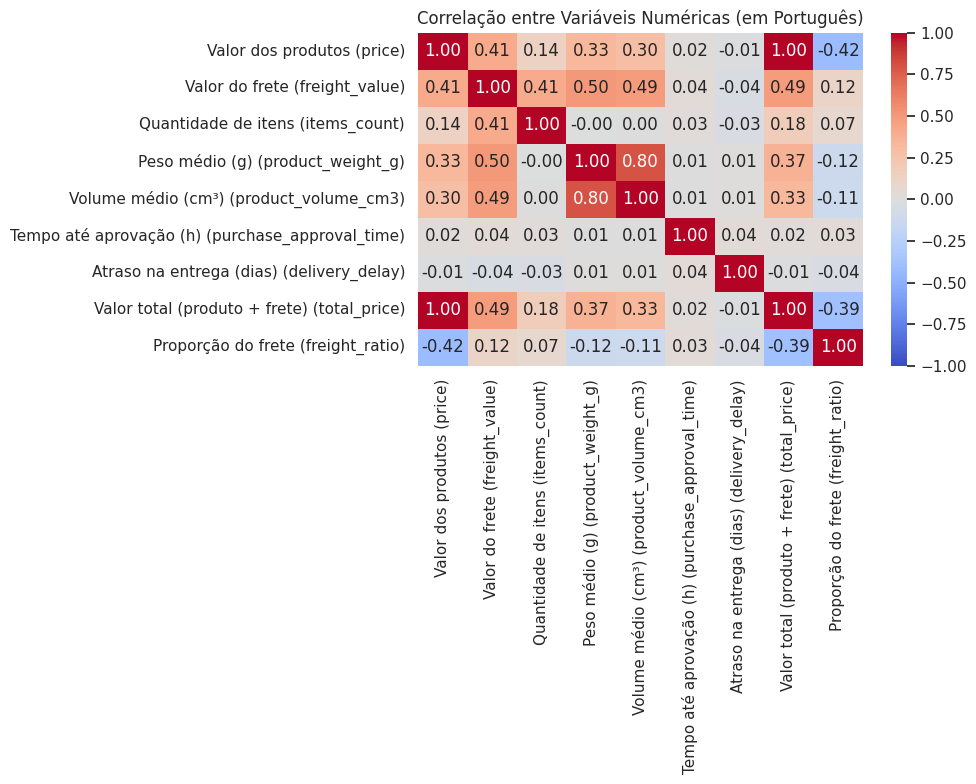

,Valor dos produtos (price),Valor do frete (freight_value),Quantidade de itens (items_count),Peso médio (g) (product_weight_g),Volume médio (cm³) (product_volume_cm3),Tempo até aprovação (h) (purchase_approval_time),Atraso na entrega (dias) (delivery_delay),Valor total (produto + frete) (total_price),Proporção do frete (freight_ratio)
Valor dos produtos (price),1.000000,0.410581,0.143396,0.334268,0.295805,0.022092,-0.008157,0.995952,-0.416460
Valor do frete (freight_value),0.410581,1.000000,0.412424,0.504686,0.489474,0.038773,-0.043219,0.490879,0.116903
Quantidade de itens (items_count),0.143396,0.412424,1.000000,-0.004081,0.001626,0.025929,-0.033953,0.177667,0.072353
Peso médio (g) (product_weight_g),0.334268,0.504686,-0.004081,1.000000,0.800071,0.007412,0.012538,0.369137,-0.124267
Volume médio (cm³) (product_volume_cm3),0.295805,0.489474,0.001626,0.800071,1.000000,0.007495,0.014667,0.330886,-0.109804
Tempo até aprovação (h) (purchase_approval_time),0.022092,0.038773,0.025929,0.007412,0.007495,1.000000,0.037883,0.024930,0.033446
Atraso na entrega (dias) (delivery_delay),-0.008157,-0.043219,-0.033953,0.012538,0.014667,0.037883,1.000000,-0.012054,-0.036096
Valor total (produto + frete) (total_price),0.995952,0.490879,0.177667,0.369137,0.330886,0.024930,-0.012054,1.000000,-0.386395
Proporção do frete (freight_ratio),-0.416460,0.116903,0.072353,-0.124267,-0.109804,0.033446,-0.036096,-0.386395,1.000000


In [ ]:
# 1. Matriz de correlação normal
corr = model_df[numeric_cols].corr()

# 2. Tradução das variáveis
map_pt = {
    "price": "Valor dos produtos",
    "freight_value": "Valor do frete",
    "items_count": "Quantidade de itens",
    "product_weight_g": "Peso médio (g)",
    "product_volume_cm3": "Volume médio (cm³)",
    "purchase_approval_time": "Tempo até aprovação (h)",
    "delivery_delay": "Atraso na entrega (dias)",
    "total_price": "Valor total (produto + frete)",
    "freight_ratio": "Proporção do frete",
}

# PT + original
map_pt_original = {col: f"{pt} ({col})" for col, pt in map_pt.items()}

# 3. Renomeia apenas linhas e colunas da matriz
corr_pt = corr.rename(index=map_pt_original, columns=map_pt_original)

# 4. Heatmap com variáveis traduzidas
plt.figure(figsize=(10,8))
sns.heatmap(corr_pt, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlação entre Variáveis Numéricas (em Português)")
plt.tight_layout()
plt.show()

corr_pt


,componente,variancia_explicada
0,PC1,0.349879
1,PC2,0.161758
2,PC3,0.141164
3,PC4,0.115233
4,PC5,0.105158


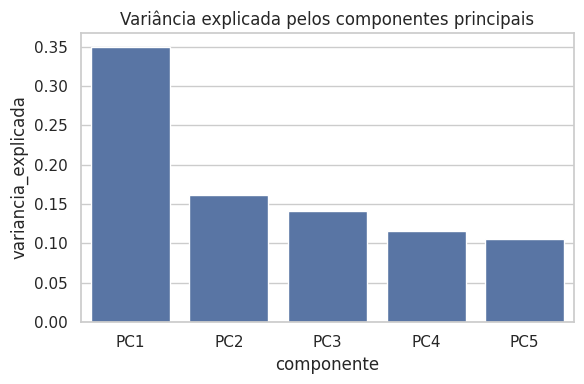

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# PCA apenas nas variáveis numéricas (padronizadas)
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(model_df[numeric_cols])

pca = PCA(n_components=5, random_state=42)
pca_components = pca.fit_transform(X_num_scaled)

explained = pd.DataFrame({
    "componente": [f"PC{i+1}" for i in range(pca.n_components_)],
    "variancia_explicada": pca.explained_variance_ratio_
})
display(explained)

plt.figure(figsize=(6,4))
sns.barplot(data=explained, x="componente", y="variancia_explicada", color="#4c72b0")
plt.title("Variância explicada pelos componentes principais")
plt.tight_layout()
plt.show()

Basicamente padronizamos as variáveis numéricas e apliquei PCA para reduzir dimensionalidade. Escolhi 5 componentes, os quais juntos emplicam cerca de 87% de toda variabilidade dos dados originais. Isso significa que podemos representar quase toda a informação quantitativa dos pedidos usando cinco componentes principais.

## 4. Partição de dados e modelagem preditiva
Treinaremos dois modelos para prever satisfação (review >= 4):
- Random Forest
- XGBoost

### Random Forest

In [ ]:
target = model_df["target_satisfied"]
features = model_df[[
    "price", "freight_value", "items_count", "product_weight_g", "product_volume_cm3",
    "purchase_approval_time", "delivery_delay", "total_price", "freight_ratio",
    "customer_state", "product_category_name_english"
]]

categorical_cols = ["customer_state", "product_category_name_english"]
numeric_cols_model = [c for c in features.columns if c not in categorical_cols]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2,
    random_state=42, stratify=target
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_cols),
        ("numeric", "passthrough", numeric_cols_model),
    ]
)

# SOMENTE RANDOM FOREST
rf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Treina o RandomForest
rf.fit(X_train, y_train)

# Previsões
preds = rf.predict(X_test)
proba = rf.predict_proba(X_test)[:, 1]

# Avaliação
acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, proba)

print(f"RandomForest: acurácia={acc:.3f}, AUC={auc:.3f}")

# Relatório
print("\nRelatório de classificação (RandomForest):")
relatorio = classification_report(
    y_test,
    preds,
    target_names=["insatisfeito", "satisfeito"],
    output_dict=True,
)

relatorio_df = pd.DataFrame(relatorio).T.rename(columns={
    "precision": "precisao",
    "recall": "revocacao",
    "f1-score": "f1",
    "support": "suporte",
})

display(relatorio_df.round(3))


RandomForest: acurácia=0.806, AUC=0.692

Relatório de classificação (RandomForest):


,precisao,revocacao,f1,suporte
insatisfeito,0.664,0.288,0.402,4419.000
satisfeito,0.821,0.957,0.884,15073.000
accuracy,0.806,0.806,0.806,0.806
macro avg,0.742,0.623,0.643,19492.000
weighted avg,0.785,0.806,0.775,19492.000


O RandomForest tem boa acurácia (enganosa), mas falha em identificar clientes insatisfeitos, uma vez que só recupera cerca de 28% deles. Como o dataset é desbalanceado, a acurácia se torna enganosa.
Para melhorar isso, vamos utilizar o XGBoost, que é um modelo mais robusto e permite aplicar pesos de classe e ajustes de limiar de decisão. Com isso, conseguimos aumentar significativamente o recall da classe ‘insatisfeito’, tornando o modelo muito mais útil do ponto de vista de negócio, mesmo que a acurácia global diminua um pouco.

### XGBoost

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_recall_fscore_support,
)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

xgb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", xgb_model),
    ]
)

# pesos maiores para a classe minoritária (insatisfeito = 0)
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

xgb_pipe.fit(X_train, y_train, model__sample_weight=sample_weights)

# probabilidade de estar satisfeito (classe 1)
proba = xgb_pipe.predict_proba(X_test)[:, 1]


# -------------------------
# TABELA DINÂMICA POR THRESHOLD
# -------------------------

thresholds = [0.5, 0.55, 0.6, 0.65, 0.70]

linhas = []

for thr in thresholds:
    preds = (proba >= thr).astype(int)

    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, proba)

    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, preds, labels=[0, 1], zero_division=0
    )

    macro_f1 = f1.mean()
    weighted_f1 = (f1 * support / support.sum()).sum()

    linhas.append({
        "threshold": thr,
        "acuracia": acc,
        "auc": auc,

        "prec_insatisfeito": precision[0],
        "recall_insatisfeito": recall[0],
        "f1_insatisfeito": f1[0],

        "prec_satisfeito": precision[1],
        "recall_satisfeito": recall[1],
        "f1_satisfeito": f1[1],

        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
    })

tabela_thresholds = pd.DataFrame(linhas)
tabela_thresholds

,threshold,acuracia,auc,prec_insatisfeito,recall_insatisfeito,f1_insatisfeito,prec_satisfeito,recall_satisfeito,f1_satisfeito,macro_f1,weighted_f1
0,0.50,0.756054,0.707018,0.463239,0.479068,0.471020,0.845731,0.837259,0.841474,0.656247,0.757489
1,0.55,0.713318,0.707018,0.403277,0.551482,0.465877,0.852628,0.760764,0.804081,0.634979,0.727407
2,0.60,0.634825,0.707018,0.340277,0.650600,0.446845,0.860183,0.630200,0.727447,0.587146,0.663832
3,0.65,0.523548,0.707018,0.291395,0.769405,0.422702,0.869760,0.451470,0.594401,0.508551,0.555475
4,0.70,0.402781,0.707018,0.258365,0.873727,0.398802,0.877309,0.264712,0.406707,0.402754,0.404915


O XGBoost trouxe um ganho muito significativo em relação ao RandomForest. Com threshold padrão de 0.5, o recall da classe ‘insatisfeito’ já sobe de 28% para 48%. Ajustando o threshold para 0.6, conseguimos detectar cerca de 65% dos clientes insatisfeitos, mais do dobro do modelo anterior.

A acurácia diminui, mas isso é esperado, pois estamos priorizando a classe minoritária, que é a mais relevante para o negócio. Thresholds maiores como 0.65 e 0.70 aumentam ainda mais o recall, mas tornam o modelo desequilibrado demais, portanto o threshold 0.60 representa o melhor compromisso entre recuperação de insatisfeitos e performance global

### Curva ROC
Comparação visual dos modelos.

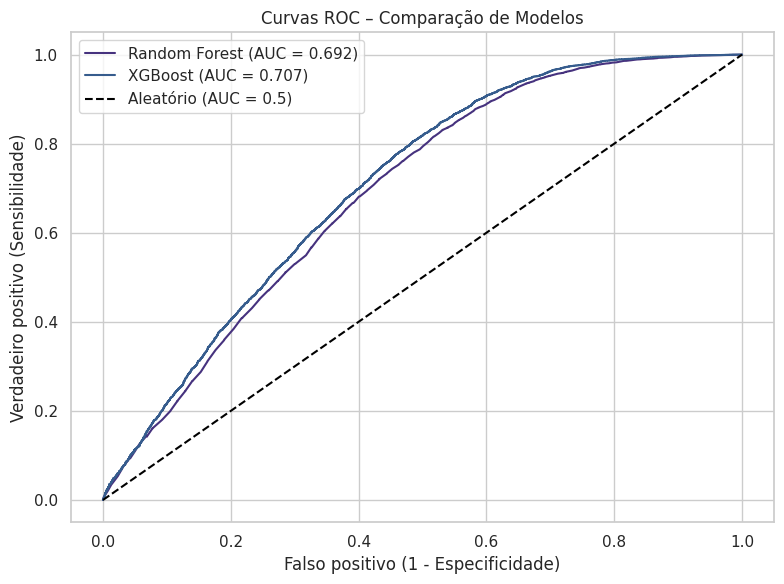

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

modelos = {
    "Random Forest": rf,
    "XGBoost": xgb_pipe,
}

plt.figure(figsize=(8, 6))

for nome, modelo in modelos.items():
    # probabilidade da classe positiva (satisfeito = 1)
    proba = modelo.predict_proba(X_test)[:, 1]

    # curva ROC
    fpr, tpr, limiares = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)

    plt.plot(fpr, tpr, label=f"{nome} (AUC = {auc:.3f})")

# linha de modelo aleatório (baseline)
plt.plot([0, 1], [0, 1], "k--", label="Aleatório (AUC = 0.5)")

plt.xlabel("Falso positivo (1 - Especificidade)")
plt.ylabel("Verdadeiro positivo (Sensibilidade)")
plt.title("Curvas ROC – Comparação de Modelos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Na comparação ROC, o XGBoost apresentou AUC de 0.707, sendo o melhor modelo entre os testados. Isso indica que ele tem maior poder discriminativo e consegue separar com mais qualidade clientes satisfeitos e insatisfeitos. O RandomForest também teve performance razoável, mas com AUC de 0.692, inferior ao XGBoost. Por isso, escolhemos o XGBoost como modelo final, especialmente por melhorar a detecção da classe minoritária, que é o foco do projeto.

## 5. Fatores críticos de satisfação

Para interpretar o XGBoost, analisamos a importância das variáveis explicativas que o modelo atribui durante o processo de boosting. Cada divisão nas árvores contribui para aumentar (ou não) o ganho de informação, e o XGBoost agrega essas contribuições ao longo de todas as árvores, gerando uma medida de importância por feature.

De forma geral, os principais fatores críticos de satisfação observados foram:

- **Atrasos de entrega (`delivery_delay`)**  
  O modelo atribui alta importância a essa variável, indicando que entregas atrasadas são um forte preditor de avaliações baixas. Quanto maior o atraso (ou quanto mais frequente), maior a probabilidade de o cliente ficar insatisfeito.

- **Custo total e proporção do frete (`total_price` e `freight_ratio`)**  
  O XGBoost também destaca o peso do custo: clientes tendem a punir pedidos com fretes caros, principalmente quando combinados com atrasos. Um frete proporcionalmente alto em relação ao valor total do pedido aumenta a chance de insatisfação.

- **Características do produto e do pedido (peso, volume, quantidade de itens)**  
  Variáveis como `product_weight_g`, `product_volume_cm3` e `items_count` aparecem como moderadamente importantes, sugerindo que produtos maiores/pesados ou pedidos com muitos itens podem estar associados a maior complexidade logística, o que afeta experiência e, indiretamente, a nota.

- **Perfil do cliente e tipo de produto (`customer_state`, `product_category_name_english`)**  
  Como essas variáveis são codificadas em várias dummies (uma por estado e uma por categoria), a importância fica “espalhada” entre muitas colunas. Ao somar por bloco (estado vs. categoria), conseguimos enxergar o peso global do perfil regional e do tipo de produto na satisfação.

Importância por grupo de variáveis (XGBoost):
                  group  importance
0  Categoria do produto    0.595936
1     Estado do cliente    0.208516
2   Variáveis numéricas    0.195548


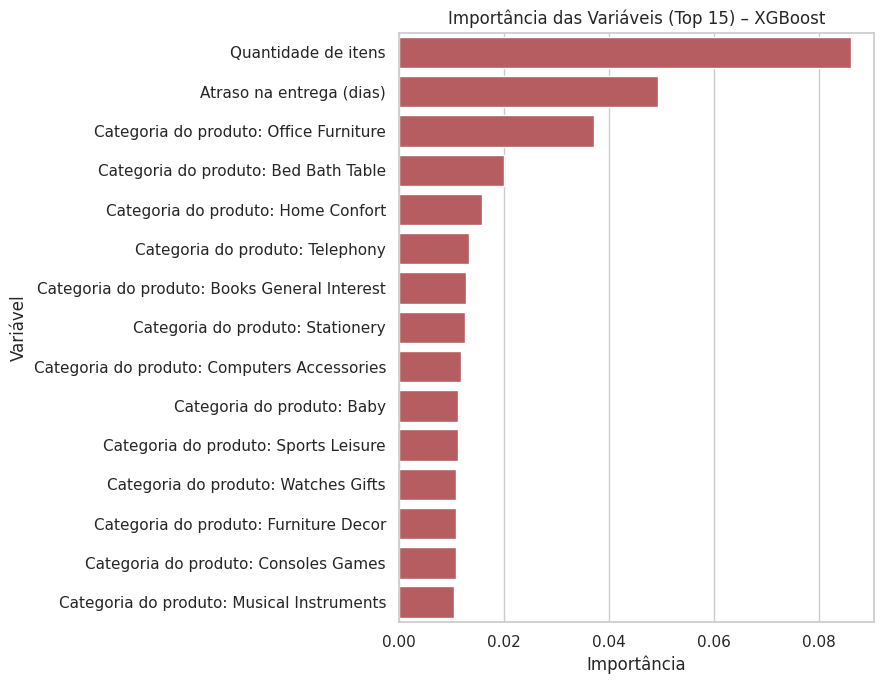

In [ ]:
# Extração de importâncias por bloco (numéricas vs categóricas) – XGBoost
xgb_model = xgb_pipe.named_steps["model"]
ohe = preprocess.named_transformers_["categorical"]

# nomes das colunas após o OneHot + numéricas
categorical_features = list(ohe.get_feature_names_out(categorical_cols))
feature_names = categorical_features + numeric_cols_model

importances = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb_model.feature_importances_,
})

# -----------------------------
# DICIONÁRIO DE TRADUÇÃO
# -----------------------------
traducao_var = {
    "price": "Preço do produto",
    "freight_value": "Valor do frete",
    "items_count": "Quantidade de itens",
    "product_weight_g": "Peso do produto (g)",
    "product_volume_cm3": "Volume do produto (cm³)",
    "purchase_approval_time": "Tempo até aprovação (h)",
    "delivery_delay": "Atraso na entrega (dias)",
    "total_price": "Preço total",
    "freight_ratio": "Proporção do frete",
}

# Tradução das variáveis categóricas (OneHot)
for cat in categorical_features:
    if cat.startswith("customer_state"):
        sigla = cat.split("_")[-1]
        traducao_var[cat] = f"Estado do cliente: {sigla.upper()}"

    elif cat.startswith("product_category_name_english"):
        categoria = cat.replace("product_category_name_english_", "")
        categoria_pt = categoria.replace("_", " ").title()
        traducao_var[cat] = f"Categoria do produto: {categoria_pt}"

# -----------------------------
# APLICAR A TRADUÇÃO
# -----------------------------
importances["feature_pt"] = importances["feature"].apply(
    lambda x: traducao_var.get(x, x)
)

# -----------------------------
# AGRUPAR PARA LEITURA MAIS SIMPLES
# -----------------------------
importances["group"] = importances["feature"].apply(
    lambda x: "Estado do cliente" if x.startswith("customer_state") else (
        "Categoria do produto" if x.startswith("product_category_name_english") else "Variáveis numéricas"
    )
)

group_importance = importances.groupby("group")["importance"].sum().reset_index()
print("Importância por grupo de variáveis (XGBoost):")
print(group_importance)

# -----------------------------
# PLOT TOP 15
# -----------------------------
top_features = importances.sort_values(by="importance", ascending=False).head(15)

plt.figure(figsize=(9, 7))
sns.barplot(data=top_features, y="feature_pt", x="importance", color="#c44e52")
plt.title("Importância das Variáveis (Top 15) – XGBoost")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()


A análise de importância das variáveis mostra que a categoria do produto é o fator mais determinante na previsão de satisfação do cliente, representando quase 60% da importância total do modelo. O estado do cliente aparece em segundo lugar, indicando que fatores geográficos afetam o desempenho logístico e a experiência do consumidor. As variáveis numéricas, como preço, frete e peso, contribuem menos para o modelo, sugerindo que a insatisfação está muito mais associada ao tipo de produto e à logística do que ao custo direto da compra.

O gráfico mostra as variáveis que mais influenciam o XGBoost na hora de prever se um cliente ficará satisfeito ou insatisfeito.

Variável mais importante: Quantidade de itens
* Pedidos com muitos itens tendem a ter maior probabilidade de atraso, extravio ou problemas logísticos.
* Isso aumenta a chance de insatisfação.
* O modelo aprendeu isso sozinho, e por isso dá muito peso a esse atributo.

2º lugar: Atraso na entrega (dias)
* Um dos fatores mais críticos na experiência do cliente.
* Atraso positivo = entrega depois do previsto → tende a gerar insatisfação.
* O modelo capta que atraso é um forte indicador de nota baixa.

A categoria do produto também influencia muito a satisfação do cliente, provavelmente porque certos tipos de produto têm maior fragilidade, maior volume, maior chance de dano, atraso ou expectativa mais alta.

## 6. Preferências regionais de consumo
Com base nos itens, analisamos:
- Principais categorias por estado.
- Nota média de satisfação por estado e categoria.

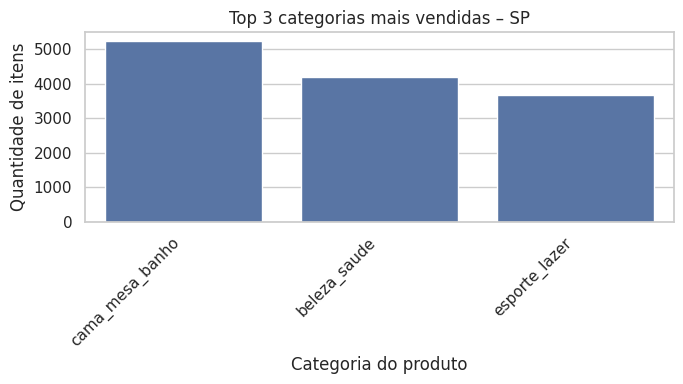

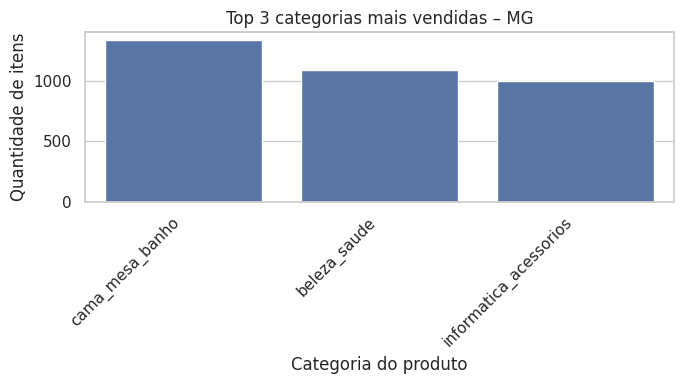

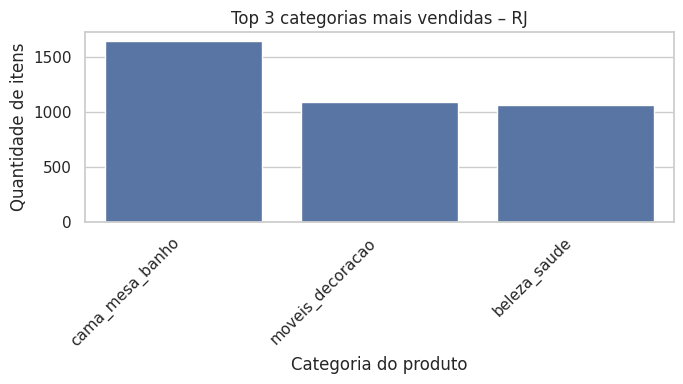

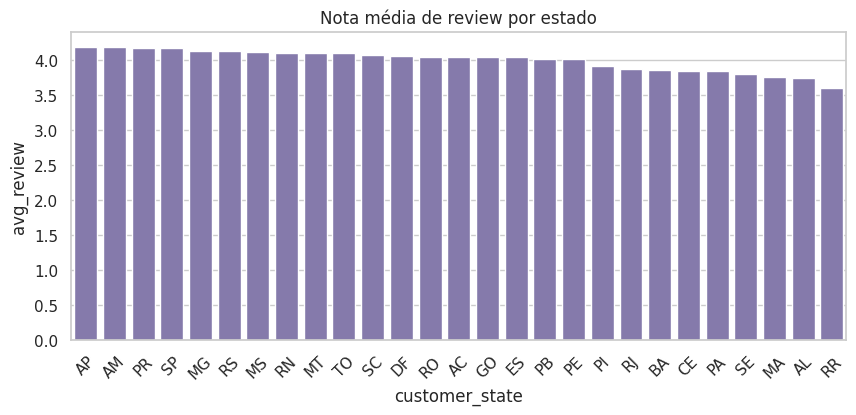

In [ ]:
# Categorias mais compradas por estado
state_category = (
    items_products
    .groupby(["customer_state", "product_category_name_english"])
    .size()
    .reset_index(name="items")
)

top_state_category = state_category.sort_values(["customer_state", "items"], ascending=[True, False]).groupby("customer_state").head(3)
top_state_category.head(10)

# Criar dicionário EN → PT
map_en_pt = dict(
    category_translation[["product_category_name_english", "product_category_name"]].values
)

# Se houver categorias sem tradução, coloca "Desconhecido"
map_en_pt = {k: (v if isinstance(v, str) else "Desconhecido") for k, v in map_en_pt.items()}

# Gerar gráficos por estado
estados = ["SP", "MG", "RJ"]

for uf in estados:
    dados_uf = (
        top_state_category[top_state_category["customer_state"] == uf]
        .sort_values("items", ascending=False)
        .copy()
    )

    # aplicar tradução
    dados_uf["categoria_pt"] = dados_uf["product_category_name_english"].map(map_en_pt)

    plt.figure(figsize=(7,4))
    sns.barplot(
        data=dados_uf,
        x="categoria_pt",
        y="items",
        color="#4c72b0"
    )
    plt.title(f"Top 3 categorias mais vendidas – {uf}")
    plt.xlabel("Categoria do produto")
    plt.ylabel("Quantidade de itens")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# Satisfação média por estado
state_score = (
    reviews
    .merge(orders[["order_id", "customer_id"]], on="order_id")
    .merge(customers[["customer_id", "customer_state"]], on="customer_id")
    .groupby("customer_state")
    .review_score.mean()
    .reset_index(name="avg_review")
)

plt.figure(figsize=(10,4))
sns.barplot(data=state_score.sort_values("avg_review", ascending=False), x="customer_state", y="avg_review", color="#8172b3")
plt.title("Nota média de review por estado")
plt.xticks(rotation=45)
plt.show()




Os gráficos para as preferências regionais nos indicam que cama_mesa_banho é o produto que mais é consumido nos 3 estados que mais compram.

Estados do Sudeste e Sul, como SP, PR e MG, apresentam as maiores notas médias, sugerindo uma experiência logística mais estável e produtos entregues dentro do esperado. Já estados do Norte e Nordeste, como RR, AL, MA e PA, têm as menores notas, o que possivelmente reflete desafios logísticos, maior distância dos centros de distribuição e maior chance de atrasos.

## 7. Conclusões ()
### **Perfil do consumidor:**
A base revela que os estados mais ativos em número de clientes e compras são São Paulo, Rio de Janeiro e Minas Gerais, refletindo maior concentração populacional e melhor acesso logístico. O ticket médio dos pedidos gira em torno de R$ 160, resultado da soma entre preço do produto e frete.

Entre os itens mais vendidos, destacam-se categorias como:

- Cama, Mesa e Banho (Bed Bath Table)
- Beleza e Saúde (Health Beauty)
- Esporte e Lazer (Sports Leisure)
- Móveis e Decoração (Furniture Decor)

Essas categorias indicam um perfil de consumo voltado principalmente para produtos de casa, cuidado pessoal e lazer.

### **Fatores críticos de satisfação:**
A análise do modelo de machine learning mostra que a satisfação do cliente está fortemente ligada a fatores logísticos. As variáveis mais importantes segundo o XGBoost foram:

- Quantidade de itens no pedido
- Atraso na entrega
- Categoria do produto

Pedidos com muitos itens apresentam maior chance de problemas logísticos, enquanto atrasos impactam diretamente a experiência do cliente. A proporção que o frete representa no valor total também influencia a nota de satisfação. Além disso, grandes quantidades de itens afetam indiretamente o atraso na entrega, uma vez que com mais itens, os quais podem vir de lugares distintos, afetam a logística, o que impacta em um possível atraso.

Além disso, algumas categorias apresentam maior tendência a avaliações negativas, sugerindo fragilidade, complexidade logística ou alta expectativa do comprador.

### **Preferências regionais:**
A análise por estado mostra diferenças claras tanto nas categorias mais compradas quanto no nível de satisfação. Cada estado apresenta top categorias próprias, refletindo preferências culturais e demandas regionais.

Quanto à satisfação, estados como AP, AM, PR, SP e MG apresentam as maiores notas médias, enquanto RR, AL, MA e PA registram as menores. Isso reforça a influência das condições logísticas regionais: estados mais afastados dos centros de distribuição tendem a sofrer mais atrasos, o que afeta diretamente a avaliação do consumidor.